# Preprocessing our dataset
<p>Streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. </p>
<p>To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as <code>danceability</code> and <code>acousticness</code> on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.</p>

In [81]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json', 
                             precise_float = True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], 
                                     on = 'track_id', how = 'inner')

# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
track_id            4802 non-null int64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


## Looking for Pairwise relationships 
<p>In order to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy.</p>
<p> So we try to get a sense of whether there are any strongly correlated features in our data.</p>

In [83]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,track_id,valence
acousticness,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.372282,-0.0138406
danceability,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.0494541,0.473165
energy,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.140703,0.0386027
instrumentalness,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.275623,-0.219967
liveness,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,0.0482307,-0.0450931
speechiness,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,-0.0269951,0.149894
tempo,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,-0.0253918,0.0522212
track_id,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,1,0.0100698
valence,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,0.0100698,1


## Splitting our data
<p> Since we didn't find any particularly strong correlations between our features, as is commonly on ML we can now split our data into an array containing our features, and another containing the labels - the genre of the track. </p>
<p>Once we have split the data into these arrays, we will perform some preprocessing steps to optimize our model development.</p>

In [85]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split

# Create features
features = echo_tracks.drop(['genre_top', 'track_id'], axis=1).values

# Create labels
labels = echo_tracks['genre_top'].values

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 10)

## Normalizing the feature data

In [87]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

## PCA on our scaled data
<p>Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. So we determine an stimate of how many dimensions are needed.</p>

Text(0.5,0,'Principal Component')

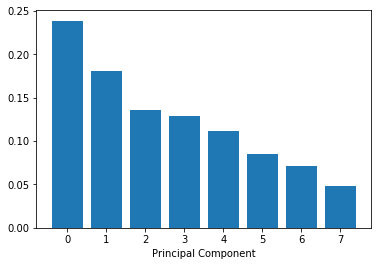

In [89]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_ 

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component')

## Visualization and settle PCA
<p> We try to look at the <strong>cumulative explained variance plot</strong> to determine how many features are required to explain, say, about 85% of the variance.</p>

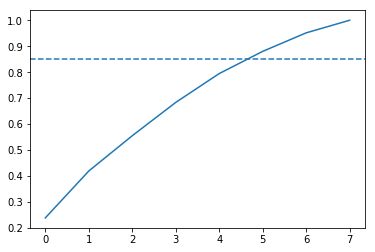

In [91]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y = 0.85, linestyle = '--')

<p>We saw from the plot that 6 features can explain 85% of the variance. Therefore, we use 6 components to perform PCA.</p>

In [93]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components = 6, random_state=10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

# Training on Data

## Decision Tree Classifier for genre
<p>Now we can use the lower dimensional PCA projection of the data to classify songs into genres. </p>


In [95]:
# Import Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)

## Compare our decision tree to a logistic regression
<p>Now, we see for applying <strong>logistic regression</strong> in order to have another model to reference performance on our Data. </p>

In [97]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.70      0.70      0.70       229
       Rock       0.93      0.93      0.93       972

avg / total       0.88      0.88      0.88      1201

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.76      0.57      0.65       229
       Rock       0.90      0.96      0.93       972

avg / total       0.88      0.88      0.88      1201



## Balance our data 
<p>Both our models do similarly well. However, looking at our classification report, we can see that rock songs are fairly well classified. Just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, this potentially skewee our model. To account for this, we ballance the proportion of songs for each gender in order to improve model's performance. </p>

In [99]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[ echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[ echo_tracks['genre_top'] == 'Rock']

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(len(hop_only), random_state = 10) 

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(features, 
                                                            labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))


<p>Does balancing our dataset improve model bias?. </p>


In [101]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree ))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.75      0.79      0.77       230
       Rock       0.77      0.73      0.75       225

avg / total       0.76      0.76      0.76       455

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.81      0.83      0.82       230
       Rock       0.83      0.80      0.82       225

avg / total       0.82      0.82      0.82       455



# Using cross-validation to evaluate our models
<p> To get a good sense of how well our models are actually performing, we can apply <strong>K - Fold cross-validation</strong> (CV). </p>
<p>Before we can perform cross-validation we will create pipelines to scale our data, perform PCA, and instantiate our model of choice - <code>DecisionTreeClassifier</code> or <code>LogisticRegression</code>.</p>

In [103]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

tree_pipe = Pipeline([("scaler", StandardScaler()), 
                      ("pca", PCA(n_components = 6)), 
                      ("tree", DecisionTreeClassifier(random_state = 10))])

logreg_pipe = Pipeline([("scaler", StandardScaler()), 
                        ("pca", PCA(n_components = 6)), 
                        ("logreg", LogisticRegression(random_state = 10))])

# Set up our K-fold cross-validation
kf = KFold(10)

# Train our models using KFold cv
tree_score = cross_val_score(tree_pipe, features, labels, cv = kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv = kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), 
      "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7219780219780221 Logistic Regression: 0.773076923076923
